In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp /content/drive/MyDrive/Colab/data.zip /content/ && unzip -q /content/data.zip -d /content/

In [ ]:
!pip install -r ./drive/MyDrive/Colab/requirements.txt

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
data_dir = "data"

print(f"Starting cleanup in: {data_dir}...")

deleted_count = 0
for root, dirs, files in os.walk(data_dir):
    for filename in files:
        file_path = os.path.join(root, filename)

        # 1. Remove hidden system files (like .DS_Store or .ipynb_checkpoints)
        if filename.startswith('.'):
            os.remove(file_path)
            deleted_count += 1
            continue

        # 2. Filter by extension
        if not filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            print(f"Removing non-image file: {file_path}")
            os.remove(file_path)
            deleted_count += 1
            continue

        # 3. Verify image integrity with TensorFlow
        try:
            img_bytes = tf.io.read_file(file_path)
            # This will throw an error if the file is corrupted or empty
            tf.io.decode_image(img_bytes)
        except tf.errors.InvalidArgumentError:
            print(f"🗑️ Deleting CORRUPTED image: {file_path}")
            os.remove(file_path)
            deleted_count += 1
        except Exception as e:
            print(f"⚠️ Error checking {file_path}: {e}")

print(f"✅ Cleanup complete. Deleted {deleted_count} problematic files.")
print("👉 ACTION: Restart your Colab session and re-run your Data Loading cell.")

Starting cleanup in: data...
🗑️ Deleting CORRUPTED image: data/training/paper/paper_898.jpg
🗑️ Deleting CORRUPTED image: data/training/paper/paper_939.jpg
✅ Cleanup complete. Deleted 2 problematic files.
👉 ACTION: Restart your Colab session and re-run your Data Loading cell.


In [ ]:
print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  print(f"✅ SUCCESS: {len(gpus)} GPU(s) found!")
  for gpu in gpus:
    print(f"   Name: {gpu.name}")
    print(f"   Details: {tf.config.experimental.get_device_details(gpu)['device_name']}")
else:
  print("❌ WARNING: No GPU found. Go to Runtime > Change runtime type > T4 GPU")


2.19.0
✅ SUCCESS: 1 GPU(s) found!
   Name: /physical_device:GPU:0
   Details: NVIDIA A100-SXM4-40GB


In [ ]:
batch_size = 32
img_height = 128
img_width = 128

directory = os.path.join(os.getcwd(),"data", "training")

In [ ]:
training_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    validation_split = 0.2, #20% of data is used for training and validation
    subset = "training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    validation_split = 0.2, #20% of data is used for testing results
    subset = "validation",
    seed=123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 15242 files belonging to 9 classes.
Using 12194 files for training.
Found 15242 files belonging to 9 classes.
Using 3048 files for validation.


In [ ]:
class_names = training_ds.class_names
print(f"Categories: {class_names}")

Categories: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes']


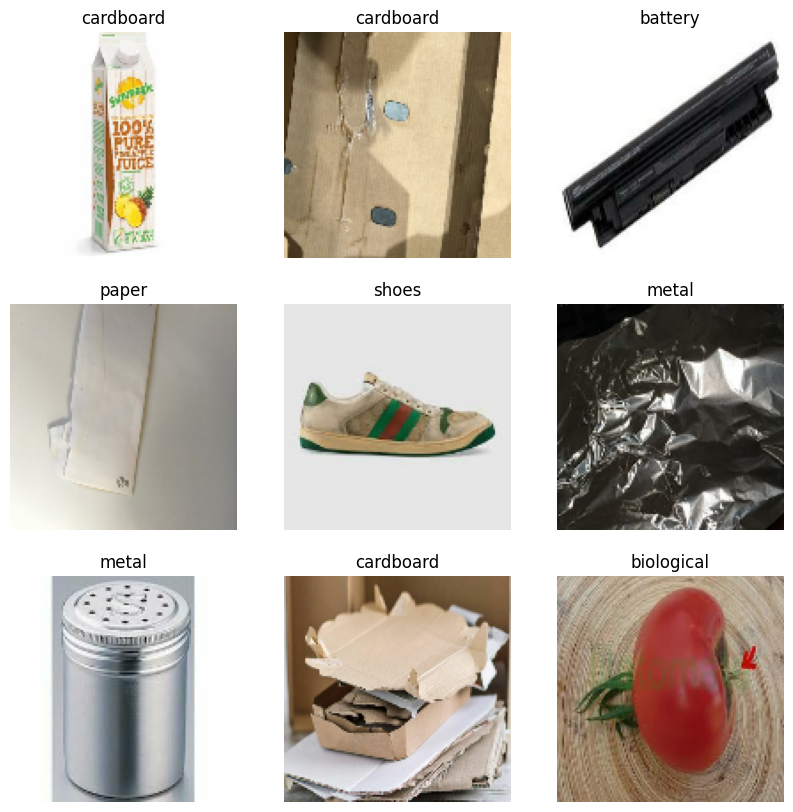

In [ ]:
plt.figure(figsize=(10,10))

for images, labels in training_ds.take(1): #takes one batch of 32
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()

In [ ]:
#without augmentation the model was overfitting even getting worse on
# validation data with loss doubling from epoch 3 to epoch 10

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal", input_shape=(img_height,img_width,3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


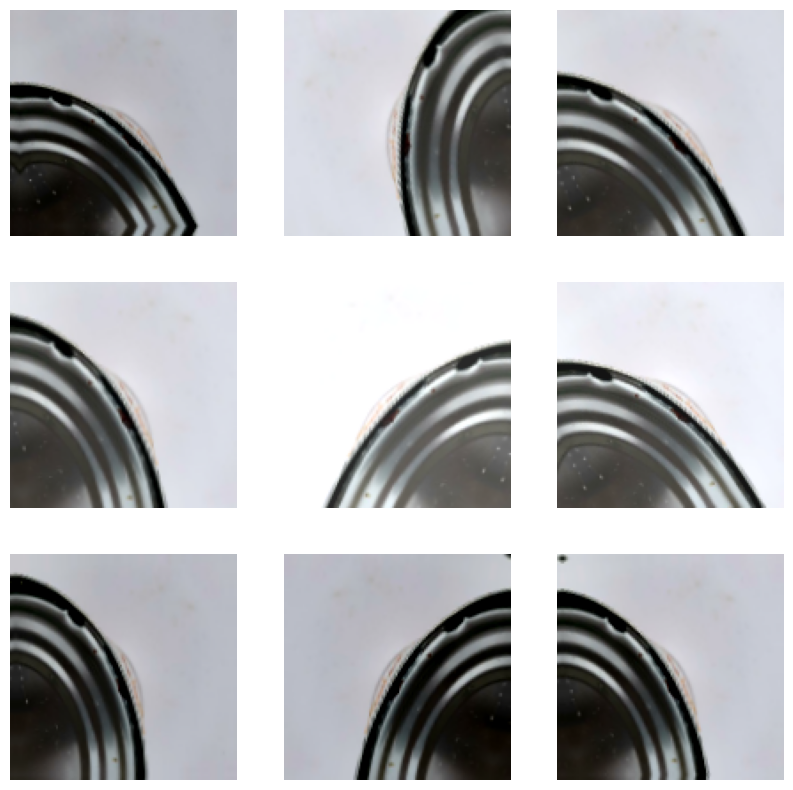

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in training_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8")) # Show 9 variations of same img
        plt.axis("off")
plt.show()

In [ ]:
# Run 1 simple CNN 128x128

num_classes = len(class_names)

model = tf.keras.Sequential([

    #Layer 1: Rescaling
    tf.keras.layers.Rescaling(1./255, input_shape=(img_height,img_width,3)),
    #LAyer2 : Kernel/Feature Finder
    tf.keras.layers.Conv2D(16,3, padding="same", activation="relu"),
    #Layer 3: Compressor (Shrinks feature maps from kernel)
    tf.keras.layers.MaxPooling2D(),

    #layer 4 & 5 (more filters for more complex patterns)
    tf.keras.layers.Conv2D(32,3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64,3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    #lyer 6: flatten
    tf.keras.layers.Flatten(),

    #layer 7: Dense 128 Neurons("make sense" of flattened list)
    tf.keras.layers.Dense(128,activation="relu"),
    #layer 8: outputs 8 numbers (highest number is models guess)
    tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_11 (Rescaling)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,122,025 (8.09 MB)

 Trainable params: 2,122,025 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#adam is teacher that adjusts weights and biases, loss is grading scale for accuracy
model.compile(
    optimizer="adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics= ["accuracy"]
)

epochs = 20

history = model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=epochs
)

model.save("run_1_128.keras")

Epoch 1/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.3157 - loss: 1.8675 - val_accuracy: 0.4905 - val_loss: 1.4304
Epoch 2/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5666 - loss: 1.2409 - val_accuracy: 0.6053 - val_loss: 1.1638
Epoch 3/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6780 - loss: 0.9682 - val_accuracy: 0.6539 - val_loss: 1.0646
Epoch 4/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7460 - loss: 0.7687 - val_accuracy: 0.6785 - val_loss: 1.0759
Epoch 5/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8288 - loss: 0.5211 - val_accuracy: 0.6670 - val_loss: 1.1369
Epoch 6/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8810 - loss: 0.3617 - val_accuracy: 0.7251 - val_loss: 1.1665
Epoch 7/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9298 - loss: 0.2261 - val_accuracy: 0.7224 - val_loss: 1.3739
Epoch 8/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9463 - loss: 0.1711 - val_acc

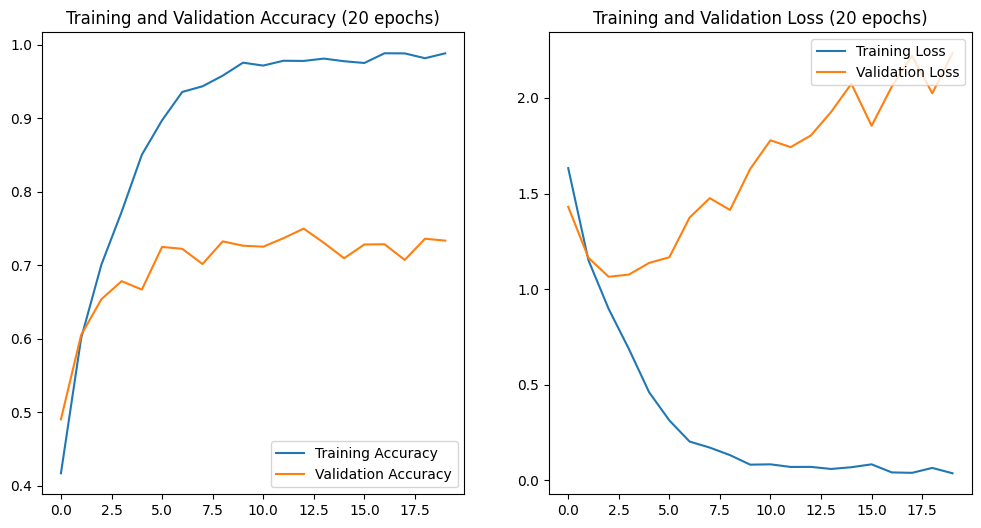

In [ ]:
acc = history.history['accuracy']
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title(f'Training and Validation Accuracy ({epochs} epochs)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title(f'Training and Validation Loss ({epochs} epochs)')

plt.show()

In [ ]:
#Run 2 add dropout to fight overfitting and data augmentation 100 epochs also add GlobalAveragePooling2D() instead of Flatten()

num_classes = len(class_names)

model = tf.keras.Sequential([
    #layer0 makes training harder by using augmentation
    data_augmentation,

    #Layer 1: Rescaling
    tf.keras.layers.Rescaling(1./255),
    #LAyer2 : Kernel/Feature Finder
    tf.keras.layers.Conv2D(16,3, padding="same", activation="relu"),
    #Layer 3: Compressor (Shrinks feature maps from kernel)
    tf.keras.layers.MaxPooling2D(),

    #layer 4 & 5 (more filters for more complex patterns)
    tf.keras.layers.Conv2D(32,3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64,3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    #lyer 6: flatten
    tf.keras.layers.GlobalAveragePooling2D(),

    #layer 7: Dense 128 Neurons("make sense" of flattened list)
    tf.keras.layers.Dense(128,activation="relu"),
    #layer 8: outputs 8 numbers (highest number is models guess)

    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_13 (Sequential)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_12 (Rescaling)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,065 (129.16 KB)

 Trainable params: 33,065 (129.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer="adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics= ["accuracy"]
)

epochs = 100

history = model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=epochs
)

model.save("run_2_128.keras")

Epoch 1/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.1761 - loss: 2.1312 - val_accuracy: 0.3166 - val_loss: 1.9056
Epoch 2/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.2947 - loss: 1.9324 - val_accuracy: 0.3438 - val_loss: 1.7903
Epoch 3/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3377 - loss: 1.8284 - val_accuracy: 0.3816 - val_loss: 1.6510
Epoch 4/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3640 - loss: 1.7371 - val_accuracy: 0.4075 - val_loss: 1.6230
Epoch 5/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4012 - loss: 1.6717 - val_accuracy: 0.4541 - val_loss: 1.5429
Epoch 6/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4132 - loss: 1.6240 - val_accuracy: 0.4350 - val_loss: 1.5459
Epoch 7/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4320 - loss: 1.5888 - val_accuracy: 0.4659 - val_loss: 1.4901
Epoch 8/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4444 - loss: 1.5523 - 

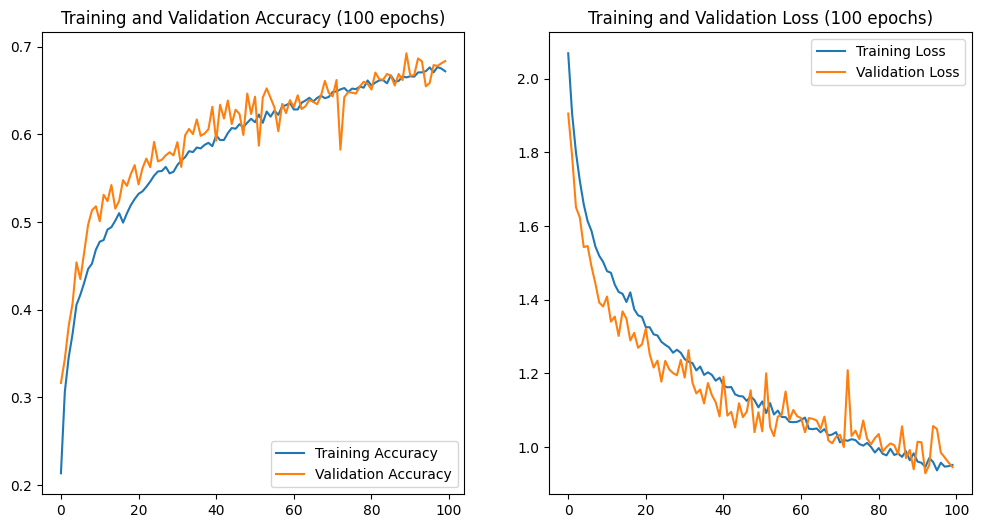

In [ ]:
acc = history.history['accuracy']
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title(f'Training and Validation Accuracy ({epochs} epochs)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title(f'Training and Validation Loss ({epochs} epochs)')

plt.show()

In [ ]:
#run 3 (bigger model, added batchnormalization and more layers, increased epochs to 200 and added callbacks)

#setup callbacks
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

my_callbacks = [tensorboard_callback, early_stopping_callback]

In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),

    # Conv Block 1
    tf.keras.layers.Conv2D(32, 3, padding="same", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),

    # Conv Block 2
    tf.keras.layers.Conv2D(64, 3, padding="same", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),

    # Conv Block 3
    tf.keras.layers.Conv2D(128, 3, padding="same", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),

    # Conv Block 4
    tf.keras.layers.Conv2D(256, 3, padding="same", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),

    # Conv Block 5
    tf.keras.layers.Conv2D(512, 3, padding="same", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.GlobalAveragePooling2D(),

    # Dense Block (The Classifier)
    tf.keras.layers.Dense(512, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(num_classes)
])

model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_8 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 128, 128, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 64, 64, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 32, 32, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 16, 16, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 8, 8, 512)      │     1,179,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_40 (Activation)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,840,361 (7.02 MB)

 Trainable params: 1,837,353 (7.01 MB)

 Non-trainable params: 3,008 (11.75 KB)

In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

epochs = 200
history = model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=my_callbacks
)

model.save("run_3_128.keras")

Epoch 1/200
382/382 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.3152 - loss: 2.0577 - val_accuracy: 0.2336 - val_loss: 2.6137
Epoch 2/200
382/382 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.4180 - loss: 1.6339 - val_accuracy: 0.3911 - val_loss: 1.9753
Epoch 3/200
382/382 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.4577 - loss: 1.5280 - val_accuracy: 0.3530 - val_loss: 2.1235
Epoch 4/200
382/382 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.5093 - loss: 1.3837 - val_accuracy: 0.4091 - val_loss: 1.7512
Epoch 5/200
382/382 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.5410 - loss: 1.3239 - val_accuracy: 0.5023 - val_loss: 1.5026
Epoch 6/200
382/382 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.5763 - loss: 1.2261 - val_accuracy: 0.4787 - val_loss: 2.1943
Epoch 7/200
382/382 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.5854 - loss: 1.1865 - val_accuracy: 0.5410 - val_loss: 1.4491
Epoch 8/200
382/382 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.6232 - loss: 1.0700 -

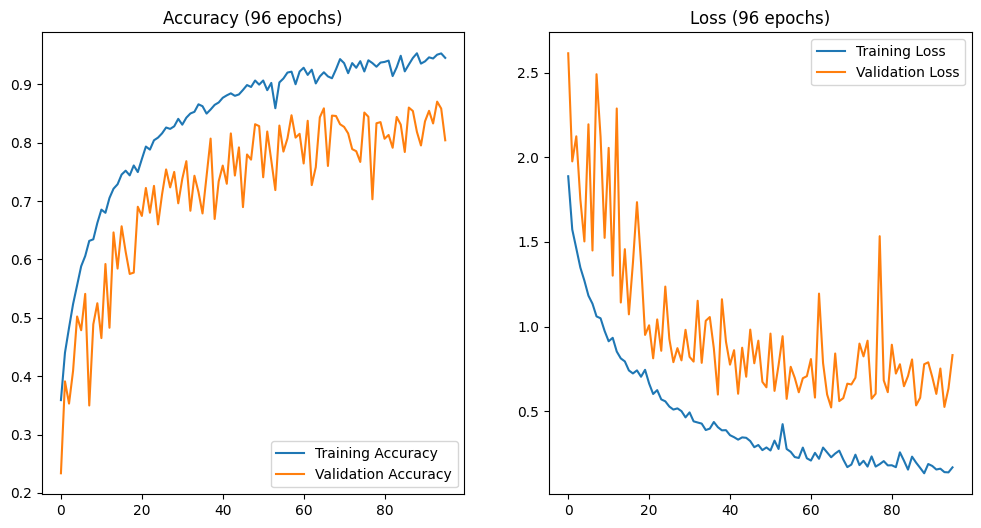

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

actual_epochs = len(acc)
epochs_range = range(actual_epochs)

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title(f'Accuracy ({actual_epochs} epochs)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title(f'Loss ({actual_epochs} epochs)')
plt.show()

In [ ]:
#RUn 4 try elu instead of relu add he_normal
#setup callbacks
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

my_callbacks = [tensorboard_callback, early_stopping_callback]

In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),

    # Conv Block 1
    tf.keras.layers.Conv2D(32, 3, padding="same", use_bias=False, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("elu"),
    tf.keras.layers.MaxPooling2D(),

    # Conv Block 2
    tf.keras.layers.Conv2D(64, 3, padding="same", use_bias=False, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("elu"),
    tf.keras.layers.MaxPooling2D(),

    # Conv Block 3
    tf.keras.layers.Conv2D(128, 3, padding="same", use_bias=False, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("elu"),
    tf.keras.layers.MaxPooling2D(),

    # Conv Block 4
    tf.keras.layers.Conv2D(256, 3, padding="same", use_bias=False, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("elu"),
    tf.keras.layers.MaxPooling2D(),

    # Conv Block 5
    tf.keras.layers.Conv2D(512, 3, padding="same", use_bias=False, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("elu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.GlobalAveragePooling2D(),

    # Dense Block (The Classifier)
    tf.keras.layers.Dense(256, use_bias=False, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("elu"),
    tf.keras.layers.Dropout(0.5),

    # Output Layer
    tf.keras.layers.Dense(num_classes)
])

model.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_9 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 128, 128, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_42 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 64, 64, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_43 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 32, 32, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_44 (Activation)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 16, 16, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_45 (Activation)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 8, 8, 512)      │     1,179,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_46 (Activation)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,705,961 (6.51 MB)

 Trainable params: 1,703,465 (6.50 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

epochs = 200
history = model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=my_callbacks
)

model.save("run_4_128.keras")

Epoch 1/200
382/382 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.2935 - loss: 2.1931 - val_accuracy: 0.3727 - val_loss: 1.8980
Epoch 2/200
382/382 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.4043 - loss: 1.7048 - val_accuracy: 0.2812 - val_loss: 2.8296
Epoch 3/200
382/382 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.4073 - loss: 1.6729 - val_accuracy: 0.4760 - val_loss: 1.5354
Epoch 4/200
382/382 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.4844 - loss: 1.4611 - val_accuracy: 0.4311 - val_loss: 1.8720
Epoch 5/200
382/382 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.4692 - loss: 1.5022 - val_accuracy: 0.5000 - val_loss: 1.4472
Epoch 6/200
382/382 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.5250 - loss: 1.3613 - val_accuracy: 0.3894 - val_loss: 1.9101
Epoch 7/200
382/382 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.5539 - loss: 1.2835 - val_accuracy: 0.4810 - val_loss: 1.5884
Epoch 8/200
382/382 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.5359 - loss: 1.3079 -

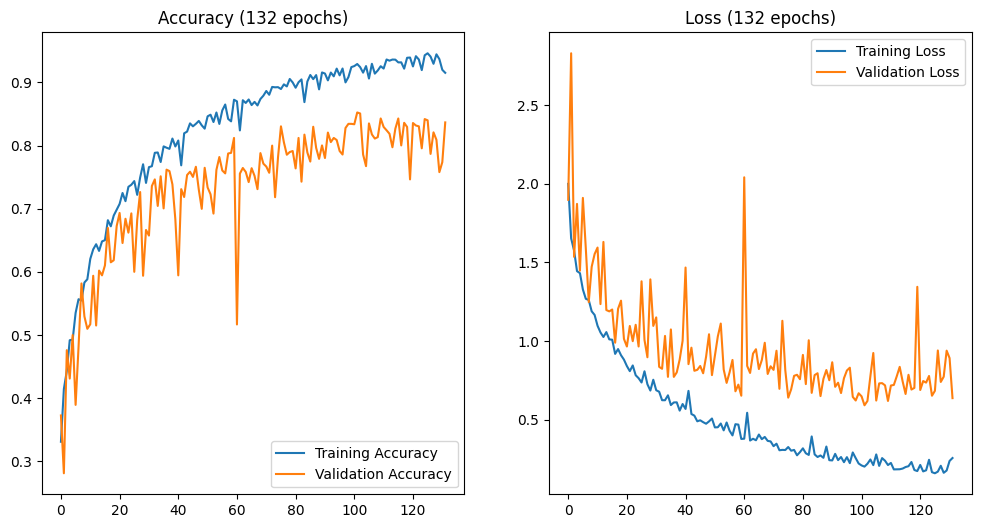

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

actual_epochs = len(acc)
epochs_range = range(actual_epochs)

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title(f'Accuracy ({actual_epochs} epochs)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title(f'Loss ({actual_epochs} epochs)')
plt.show()

In [ ]:
#RUn 5 higher resolution for images add ReduceLROnPlateau (gear shifter) to callback to limit jittering towards end
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping_callback= tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

reduce_learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=0.00001,
    verbose=1,
)

my_callbacks = [tensorboard_callback, reduce_learning_rate_callback , early_stopping_callback]

In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),

    # Conv Block 1
    tf.keras.layers.Conv2D(32, 3, padding="same", use_bias=False, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("elu"),
    tf.keras.layers.MaxPooling2D(),

    # Conv Block 2
    tf.keras.layers.Conv2D(64, 3, padding="same", use_bias=False, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("elu"),
    tf.keras.layers.MaxPooling2D(),

    # Conv Block 3
    tf.keras.layers.Conv2D(128, 3, padding="same", use_bias=False, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("elu"),
    tf.keras.layers.MaxPooling2D(),

    # Conv Block 4
    tf.keras.layers.Conv2D(256, 3, padding="same", use_bias=False, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("elu"),
    tf.keras.layers.MaxPooling2D(),

    # Conv Block 5
    tf.keras.layers.Conv2D(512, 3, padding="same", use_bias=False, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("elu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.GlobalAveragePooling2D(),

    # Dense Block (The Classifier)
    tf.keras.layers.Dense(256, use_bias=False, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("elu"),
    tf.keras.layers.Dropout(0.5),

    # Output Layer
    tf.keras.layers.Dense(num_classes)
])

model.summary()


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_11 (Sequential)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_10 (Rescaling)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 256, 256, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_48 (Activation)      │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 128, 128, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_49 (Activation)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 64, 64, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_50 (Activation)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 32, 32, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_51 (Activation)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 16, 16, 512)    │     1,179,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_52 (Activation)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,705,961 (6.51 MB)

 Trainable params: 1,703,465 (6.50 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

epochs = 200
history = model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=my_callbacks
)

model.save("run_5_256.keras")

Epoch 1/200
382/382 ━━━━━━━━━━━━━━━━━━━━ 25s 52ms/step - accuracy: 0.2642 - loss: 2.2749 - val_accuracy: 0.4111 - val_loss: 1.7059 - learning_rate: 0.0010
Epoch 2/200
382/382 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.3807 - loss: 1.7636 - val_accuracy: 0.2956 - val_loss: 2.1219 - learning_rate: 0.0010
Epoch 3/200
382/382 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.4137 - loss: 1.6437 - val_accuracy: 0.4364 - val_loss: 1.6222 - learning_rate: 0.0010
Epoch 4/200
382/382 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.4559 - loss: 1.5240 - val_accuracy: 0.4409 - val_loss: 1.7242 - learning_rate: 0.0010
Epoch 5/200
382/382 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.4720 - loss: 1.4724 - val_accuracy: 0.4101 - val_loss: 1.8282 - learning_rate: 0.0010
Epoch 6/200
382/382 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.5042 - loss: 1.3973 - val_accuracy: 0.3953 - val_loss: 1.7694 - learning_rate: 0.0010
Epoch 7/200
382/382 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.4

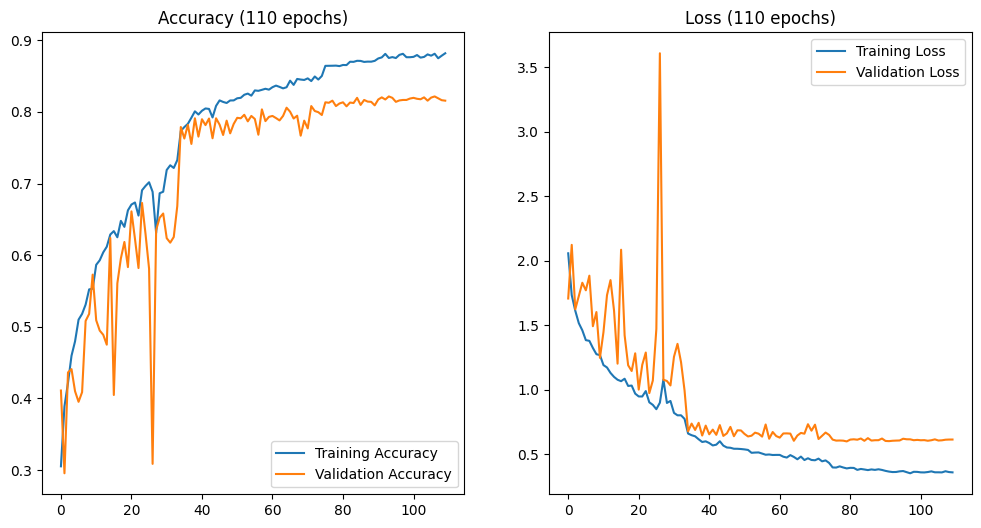

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

actual_epochs = len(acc)
epochs_range = range(actual_epochs)

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title(f'Accuracy ({actual_epochs} epochs)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title(f'Loss ({actual_epochs} epochs)')
plt.show()

#__________-------END OF RUNS-----

In [ ]:
model_filename = 'run_2_128.keras'

In [ ]:
model.save(model_filename)

In [ ]:
#CREATING CONFUSION MATRIX

import numpy as np

loaded_model = tf.keras.models.load_model(model_filename)

y_true = []
y_pred = []

for images, labels in validation_ds:
    predictions = loaded_model.predict(images, verbose=0)

    #argmax to pick index of highest number
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

     battery       0.77      0.60      0.67       163
  biological       0.90      0.64      0.75       155
   cardboard       0.68      0.87      0.76       404
     clothes       0.78      0.80      0.79       408
       glass       0.69      0.73      0.71       497
       metal       0.55      0.64      0.59       269
       paper       0.59      0.67      0.63       385
     plastic       0.71      0.56      0.62       462
       shoes       0.70      0.53      0.60       305

    accuracy                           0.68      3048
   macro avg       0.71      0.67      0.68      3048
weighted avg       0.69      0.68      0.68      3048



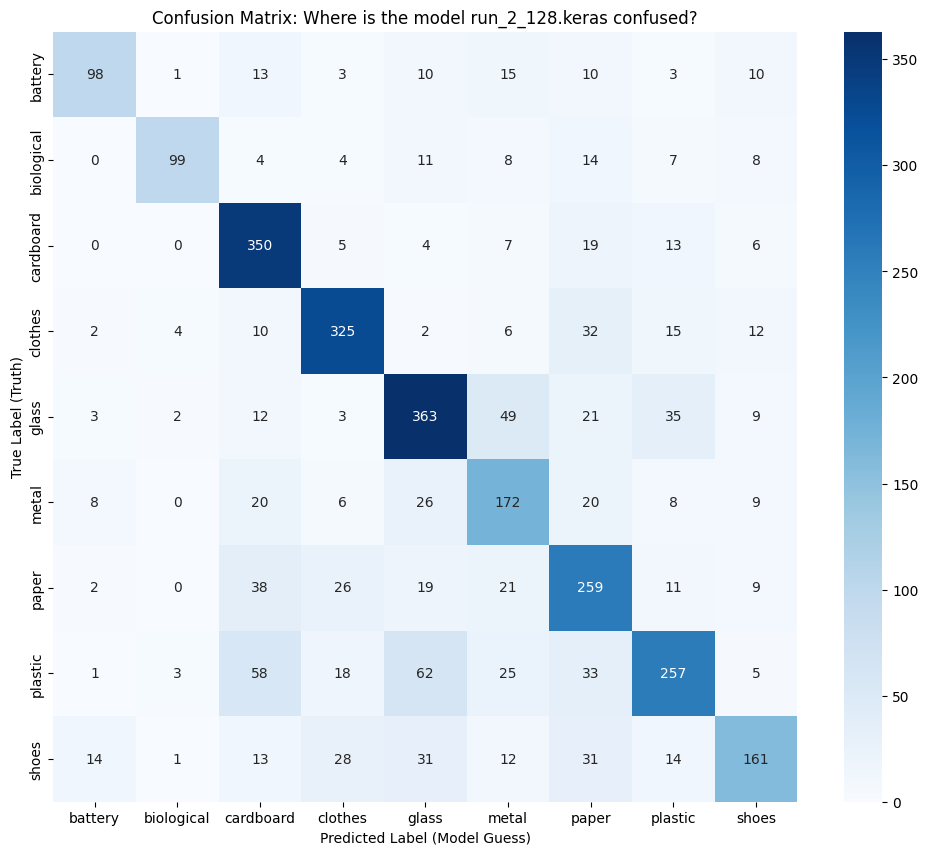

In [ ]:
# 1. Calculate the Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 2. Plot it as a Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title(f'Confusion Matrix: Where is the model {model_filename} confused?')
plt.ylabel('True Label (Truth)')
plt.xlabel('Predicted Label (Model Guess)')
plt.show()